In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type

## Load In the Data

In [2]:
skin_df = pd.read_csv('C:/Users/somiseta/isic2018/hmnist_64_64_RBG.csv')

In [3]:
skin_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,191,152,194,191,153,195,192,149,192,194,...,185,154,180,186,156,184,182,152,173,2
1,24,13,23,24,14,28,37,24,46,61,...,26,15,29,27,15,28,24,13,25,2
2,185,129,140,192,136,151,198,142,156,198,...,152,120,138,144,113,123,115,81,84,2
3,24,11,19,36,19,30,64,38,50,91,...,27,13,16,25,12,16,24,9,14,2
4,138,94,117,158,113,138,178,133,161,191,...,140,106,118,108,77,92,67,40,55,2


In [4]:
X = skin_df.drop("label", axis=1).as_matrix()  # converting to numpy array 
label = skin_df["label"].values 

In [5]:
X.shape, label.shape

((10015, 12288), (10015,))

## Scaling and Split Data into Train, Validation and Test set

In [6]:
X_mean = np.mean(X)
X_std = np.std(X)

X = (X - X_mean)/X_std    #Scaling the data

In [7]:
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, label, test_size=0.1,random_state=0)

In [8]:
X_train_orig.shape, X_test.shape, y_train_orig.shape, y_test.shape

((9013, 12288), (1002, 12288), (9013,), (1002,))

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.2, random_state=1)

In [10]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7210, 12288), (1803, 12288), (7210,), (1803,))

## Reshape the Data to Input in CNN

In [11]:
X_train = X_train.reshape(X_train.shape[0], *(64, 64, 3))
X_val = X_val.reshape(X_val.shape[0], *(64, 64, 3))
X_test = X_test.reshape(X_test.shape[0], *(64, 64, 3))

In [12]:
X_train.shape, X_val.shape, X_test.shape

((7210, 64, 64, 3), (1803, 64, 64, 3), (1002, 64, 64, 3))

In [13]:
y_train.shape

(7210,)

In [14]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [15]:
y_train.shape, y_val.shape, y_test.shape

((7210, 7), (1803, 7), (1002, 7))

## CNN Model

In [16]:
# Our input feature map is 64x64x3: 64x64 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(64, 64, 3))

In [17]:
# Extraction of 16 filters
# max-pooling is done with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

In [18]:
# Extraction of 32 filters
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

In [19]:
# Extraction of 64 filters 
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

In [20]:
# Feature map extraction to a 1-dim tensor
x = layers.Flatten()(x)

# Contians fully connected layer with activation function as RELU which consists of 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5 
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model
model = Model(img_input, output)

#Using Adam Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [22]:
#Generate batches of tensor image data with real-time data augmentation
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.15, horizontal_flip=True, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [23]:
#Reduce learning rate when a metric has stopped improving.

#Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
#This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [24]:
batch_size = 32
epochs = 40
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/40
225/225 [==============================] - 13s 58ms/step - loss: 0.9713 - acc: 0.6679 - val_loss: 0.8841 - val_acc: 0.6822
Epoch 2/40
225/225 [==============================] - 8s 34ms/step - loss: 0.8473 - acc: 0.6919 - val_loss: 0.8683 - val_acc: 0.6850
Epoch 3/40
225/225 [==============================] - 8s 34ms/step - loss: 0.8059 - acc: 0.7075 - val_loss: 0.7755 - val_acc: 0.7277
Epoch 4/40
225/225 [==============================] - 7s 33ms/step - loss: 0.7651 - acc: 0.7189 - val_loss: 0.7396 - val_acc: 0.7266
Epoch 5/40
225/225 [==============================] - 8s 34ms/step - loss: 0.7473 - acc: 0.7195 - val_loss: 0.7518 - val_acc: 0.7388
Epoch 6/40
225/225 [==============================] - 8s 34ms/step - loss: 0.7235 - acc: 0.7340 - val_loss: 0.7085 - val_acc: 0.7476
Epoch 7/40
225/225 [==============================] - 8s 34ms/step - loss: 0.6985 - acc: 0.7363 - val_loss: 0.6878 - val_acc: 0.7432
Epoch 8/40
225/225 [==============================] - 7s 33ms/step -

In [ ]:
batch_size = 32
epochs = 40
history_test = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_test, y_test),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

In [25]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
model.save("base_model.h5")

1803/1803 [==============================] - 0s 196us/step
Validation: accuracy = 0.768164  ;  loss_v = 0.616828
Test: accuracy = 0.760479  ;  loss = 0.664191


<Figure size 432x288 with 0 Axes>

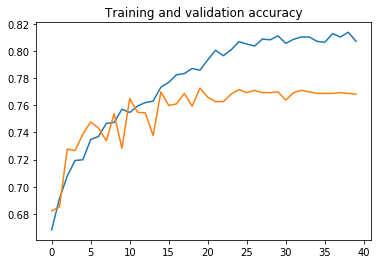

<Figure size 432x288 with 0 Axes>

In [33]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']


# Retrieve a list of list results on training and test data

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()


Text(0.5, 1.0, 'Training and validation loss')

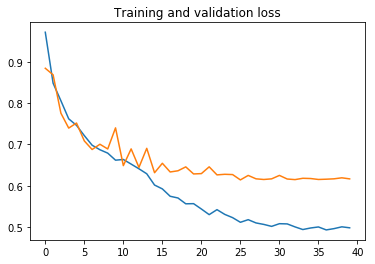

In [34]:

# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']




# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
